In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.4 MB/s eta 0:00:00


In [11]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm 
from tqdm import tqdm
import gc # 가비지 컬렉터

# ==========================================
# 1. Configuration (배치 사이즈 수정됨)
# ==========================================
CONFIG = {
    'data_dir': '../data',   
    'img_size': 299,         # Xception 권장 해상도
    'batch_size': 16,        # [중요] 32 -> 16으로 축소 (메모리 확보)
    'learning_rate': 0.0001,
    'epochs': 3,
    'seed': 42,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

torch.manual_seed(CONFIG['seed'])

# ... (이하 Dataset 및 Transform 코드는 기존과 동일하므로 생략하지 않고 전체 실행 필요) ...
# (편의를 위해 아래 전체 코드를 다시 드립니다)
class DeepDetectDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.image_paths = file_paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            return torch.zeros((3, CONFIG['img_size'], CONFIG['img_size'])), torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, torch.tensor(self.labels[idx], dtype=torch.float32)

# Transforms (299x299)
basic_transform = A.Compose([
    A.Resize(height=CONFIG['img_size'], width=CONFIG['img_size'], interpolation=3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

aug_transform = A.Compose([
    A.Resize(height=CONFIG['img_size'], width=CONFIG['img_size'], interpolation=3),
    A.HorizontalFlip(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.ImageCompression(quality_lower=60, quality_upper=100, p=0.3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=CONFIG['img_size'], width=CONFIG['img_size'], interpolation=3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

# Helper Functions
def load_file_paths(root_dir):
    file_paths, labels = [], []
    for label, class_name in enumerate(['Real', 'Fake']): 
        target_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(target_dir): target_dir = os.path.join(root_dir, class_name.lower())
        if os.path.exists(target_dir):
            files = [os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
            file_paths.extend(files)
            labels.extend([label] * len(files))
    return file_paths, labels

def get_dataloaders(data_dir, train_transform_logic):
    train_dir = os.path.join(data_dir, 'train')
    train_paths, train_labels = load_file_paths(train_dir)
    
    test_root_dir = os.path.join(data_dir, 'test')
    all_test_paths, all_test_labels = load_file_paths(test_root_dir)
    
    if len(train_paths) == 0 or len(all_test_paths) == 0: raise ValueError("데이터 부족")

    val_paths, final_test_paths, val_labels, final_test_labels = train_test_split(
        all_test_paths, all_test_labels, test_size=0.5, random_state=CONFIG['seed'], stratify=all_test_labels
    )
    
    train_dataset = DeepDetectDataset(train_paths, train_labels, transform=train_transform_logic)
    val_dataset = DeepDetectDataset(val_paths, val_labels, transform=val_transform)
    test_dataset = DeepDetectDataset(final_test_paths, final_test_labels, transform=val_transform)

    print(f"✅ 데이터셋 구성 완료 (Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)})")

    return {
        'train': DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2),
        'val': DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2),
        'test': DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    }

def get_xception_model():
    model = timm.create_model('xception', pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 1),
        nn.Sigmoid()
    )
    return model

def train(model, loaders, criterion, optimizer, epochs, save_name):
    # [추가] 학습 시작 전 메모리 정리
    torch.cuda.empty_cache()
    gc.collect()
    
    model = model.to(CONFIG['device'])
    best_acc = 0.0
    print(f"🚀 학습 시작: {save_name} (Batch: {CONFIG['batch_size']})")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss, corrects, total = 0.0, 0, 0
            loop = tqdm(loaders[phase], leave=True, mininterval=1.0)
            
            for inputs, labels in loop:
                inputs = inputs.to(CONFIG['device'])
                labels = labels.to(CONFIG['device']).float().unsqueeze(1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = (outputs > 0.5).float()
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)
                total += inputs.size(0)
                
                loop.set_description(f"[{phase}]")
                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss / total
            epoch_acc = corrects.double() / total
            print(f"[{phase}] Final Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), save_name)
                print(f"✅ Best Model Saved! Acc: {best_acc:.4f}")
        print("-" * 30)

In [12]:
# ==========================================
# 데이터 로더 생성 (Loader Preparation)
# ==========================================
if os.path.exists(CONFIG['data_dir']):
    print("📦 데이터 로더 생성을 시작합니다...")

    # 1. 실험 1용 로더 (증강 없음: basic_transform)
    #    - Train 데이터가 깨끗한 상태로 유지됨
    print("\n[1/2] 실험 1용 로더 (No Augmentation) 생성 중...")
    loaders_no_aug = get_dataloaders(CONFIG['data_dir'], basic_transform)

    # 2. 실험 2용 로더 (증강 적용: aug_transform)
    #    [cite_start]- Train 데이터에 Blur, Compression 등이 적용됨 [cite: 82-87]
    print("\n[2/2] 실험 2용 로더 (With Augmentation) 생성 중...")
    loaders_aug = get_dataloaders(CONFIG['data_dir'], aug_transform)

    print("\n✅ 모든 데이터 로더 준비 완료!")
else:
    print("❌ 오류: 데이터 경로를 확인해주세요.")

📦 데이터 로더 생성을 시작합니다...

[1/2] 실험 1용 로더 (No Augmentation) 생성 중...
✅ 데이터셋 구성 완료 (Train: 90409, Val: 10888, Test: 10888)

[2/2] 실험 2용 로더 (With Augmentation) 생성 중...
✅ 데이터셋 구성 완료 (Train: 90409, Val: 10888, Test: 10888)

✅ 모든 데이터 로더 준비 완료!


In [13]:
# ==========================================
# 실험 1: 증강 없음 (No Augmentation) - Xception
# ==========================================
if 'loaders_no_aug' in locals():
    print("\n" + "="*40)
    print("🧪 실험 1 시작: No Augmentation (Xception)")
    print("="*40)
    
    # 1. 모델 초기화 (Xception 함수 사용)
    model_no_aug = get_xception_model()
    
    # 2. Loss & Optimizer
    criterion = nn.BCELoss()
    optimizer_no_aug = optim.Adam(model_no_aug.parameters(), lr=CONFIG['learning_rate'])
    
    # 3. 학습 실행
    train(model_no_aug, loaders_no_aug, criterion, optimizer_no_aug, 
          CONFIG['epochs'], save_name='xception_no_aug.pth') 
else:
    print("❌ Error: loaders_no_aug가 정의되지 않았습니다. [Cell 4] 로더 생성 셀을 먼저 실행해주세요.")


🧪 실험 1 시작: No Augmentation (Xception)


/usr/local/lib/python3.8/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


🚀 학습 시작: xception_no_aug.pth (Batch: 16)
Epoch 1/3


[train]: 100%|█████████████████| 5651/5651 [16:13<00:00,  5.80it/s, loss=0.0196]


[train] Final Loss: 0.0487 Acc: 0.9825


[val]: 100%|███████████████████████| 681/681 [00:32<00:00, 20.95it/s, loss=1.17]


[val] Final Loss: 3.7868 Acc: 0.5711
✅ Best Model Saved! Acc: 0.5711
------------------------------
Epoch 2/3


[train]: 100%|████████████████| 5651/5651 [15:08<00:00,  6.22it/s, loss=2.35e-5]


[train] Final Loss: 0.0088 Acc: 0.9972


[val]: 100%|████████████████████████| 681/681 [00:31<00:00, 21.56it/s, loss=0.8]


[val] Final Loss: 5.8075 Acc: 0.5396
------------------------------
Epoch 3/3


[train]: 100%|████████████████| 5651/5651 [15:49<00:00,  5.95it/s, loss=1.99e-5]


[train] Final Loss: 0.0063 Acc: 0.9979


[val]: 100%|██████████████████████| 681/681 [00:33<00:00, 20.56it/s, loss=0.083]


[val] Final Loss: 1.6980 Acc: 0.7882
✅ Best Model Saved! Acc: 0.7882
------------------------------


In [14]:
# ==========================================
# 실험 2: 증강 적용 (With Augmentation) - Xception
# ==========================================
if 'loaders_aug' in locals():
    print("\n" + "="*40)
    print("🧪 실험 2 시작: With Augmentation (Xception)")
    print("="*40)
    
    # 1. 모델 초기화 (Xception 함수 사용)
    model_aug = get_xception_model() # [수정됨] ResNet -> Xception
    
    # 2. Loss & Optimizer
    criterion = nn.BCELoss()
    optimizer_aug = optim.Adam(model_aug.parameters(), lr=CONFIG['learning_rate'])
    
    # 3. 학습 실행 (미리 만든 loaders_aug 사용)
    # [수정됨] 저장 파일명을 xception으로 변경
    train(model_aug, loaders_aug, criterion, optimizer_aug, 
          CONFIG['epochs'], save_name='xception_with_aug.pth')
else:
    print("❌ Error: loaders_aug가 정의되지 않았습니다. [Cell 4] 로더 생성 셀을 먼저 실행해주세요.")


🧪 실험 2 시작: With Augmentation (Xception)
🚀 학습 시작: xception_with_aug.pth (Batch: 16)
Epoch 1/3


[train]: 100%|███████████████| 5651/5651 [15:48<00:00,  5.96it/s, loss=0.000992]


[train] Final Loss: 0.0801 Acc: 0.9704


[val]: 100%|███████████████████| 681/681 [00:32<00:00, 20.71it/s, loss=0.000804]


[val] Final Loss: 0.3326 Acc: 0.9201
✅ Best Model Saved! Acc: 0.9201
------------------------------
Epoch 2/3


[train]: 100%|█████████████████| 5651/5651 [14:31<00:00,  6.48it/s, loss=0.0295]


[train] Final Loss: 0.0228 Acc: 0.9921


[val]: 100%|██████████████████████| 681/681 [00:25<00:00, 26.32it/s, loss=0.717]


[val] Final Loss: 0.8039 Acc: 0.8350
------------------------------
Epoch 3/3


[train]: 100%|███████████████| 5651/5651 [11:34<00:00,  8.14it/s, loss=0.000381]


[train] Final Loss: 0.0165 Acc: 0.9947


[val]: 100%|████████████████████| 681/681 [00:25<00:00, 26.63it/s, loss=0.00825]


[val] Final Loss: 0.9269 Acc: 0.9296
✅ Best Model Saved! Acc: 0.9296
------------------------------


In [16]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

# ==========================================
# 1. 모델 구조 정의 (Xception)
# ==========================================
def get_xception_model():
    model = timm.create_model('xception', pretrained=False) # 가중치 로드할 거라 False
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 1),
        nn.Sigmoid()
    )
    return model

# ==========================================
# 2. 추론 엔진 (Inference Function)
# ==========================================
def run_inference(model_path, loader, device):
    print(f"🚀 모델 로딩 중... ({model_path})")
    
    # 모델 초기화 및 가중치 로드
    model = get_xception_model().to(device)
    
    if os.path.exists(model_path):
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
        except Exception as e:
            print(f"❌ 가중치 로드 에러: {e}")
            return None, None
    else:
        print(f"❌ 파일이 없습니다: {model_path}")
        return None, None

    model.eval()
    y_true, y_probs = [], []
    
    # 추론 루프
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images).squeeze()
            
            # 배치 크기가 1일 때 차원 유지
            if outputs.ndim == 0: outputs = outputs.unsqueeze(0)
                
            probs = outputs.cpu().numpy()
            y_true.extend(labels.numpy())
            y_probs.extend(probs)
            
    return np.array(y_true), np.array(y_probs)

# ==========================================
# 3. 시각화 함수 (Visualization)
# ==========================================
def show_model_performance(y_true, y_probs, title):
    y_pred = (y_probs > 0.5).astype(int)
    
    # 지표 계산
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print("\n" + "="*60)
    print(f"📢 [{title}] 성능 리포트")
    print("="*60)
    print(f"✅ Accuracy : {acc*100:.2f}%")
    print(f"✅ F1 Score : {f1:.4f}")
    
    # 그래프 그리기
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # (1) Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    axes[0].set_title(f'{title}\nConfusion Matrix')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    # (2) ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1].set_title(f'{title}\nROC Curve')
    axes[1].legend(loc="lower right")

    # (3) Prediction Distribution
    axes[2].hist(y_probs[y_true==0], bins=50, alpha=0.5, label='Real', color='blue')
    axes[2].hist(y_probs[y_true==1], bins=50, alpha=0.5, label='Fake', color='red')
    axes[2].set_title(f'{title}\nPrediction Distribution')
    axes[2].legend()
    
    plt.tight_layout()

    # ==========================================
    # [추가됨] 이미지 저장 로직
    # ==========================================
    save_dir = './image'
    os.makedirs(save_dir, exist_ok=True) # 폴더가 없으면 생성
    
    # 파일명 생성 (공백 -> 언더바, 괄호 제거 등 파일명에 안 좋은 문자 정리)
    safe_title = title.replace(" ", "_").replace("(", "").replace(")", "")
    filename = f"{safe_title}.png"
    save_path = os.path.join(save_dir, filename)
    
    plt.savefig(save_path) # plt.show() 전에 저장해야 백지 현상 방지
    print(f"💾 그래프가 저장되었습니다: {save_path}")

    plt.show()

🧐 총 4번의 평가를 시작합니다.


🟦 [Model: No Augmentation (Xception)] 평가 시작...
   ▶ Dataset: Validation Set (10888장)
🚀 모델 로딩 중... (xception_no_aug.pth)


/tmp/ipykernel_64032/3577255946.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
Evaluating: 100%|████


📢 [No Augmentation (Xception) on Validation Set] 성능 리포트
✅ Accuracy : 78.82%
✅ F1 Score : 0.8183
💾 그래프가 저장되었습니다: ./image/No_Augmentation_Xception_on_Validation_Set.png


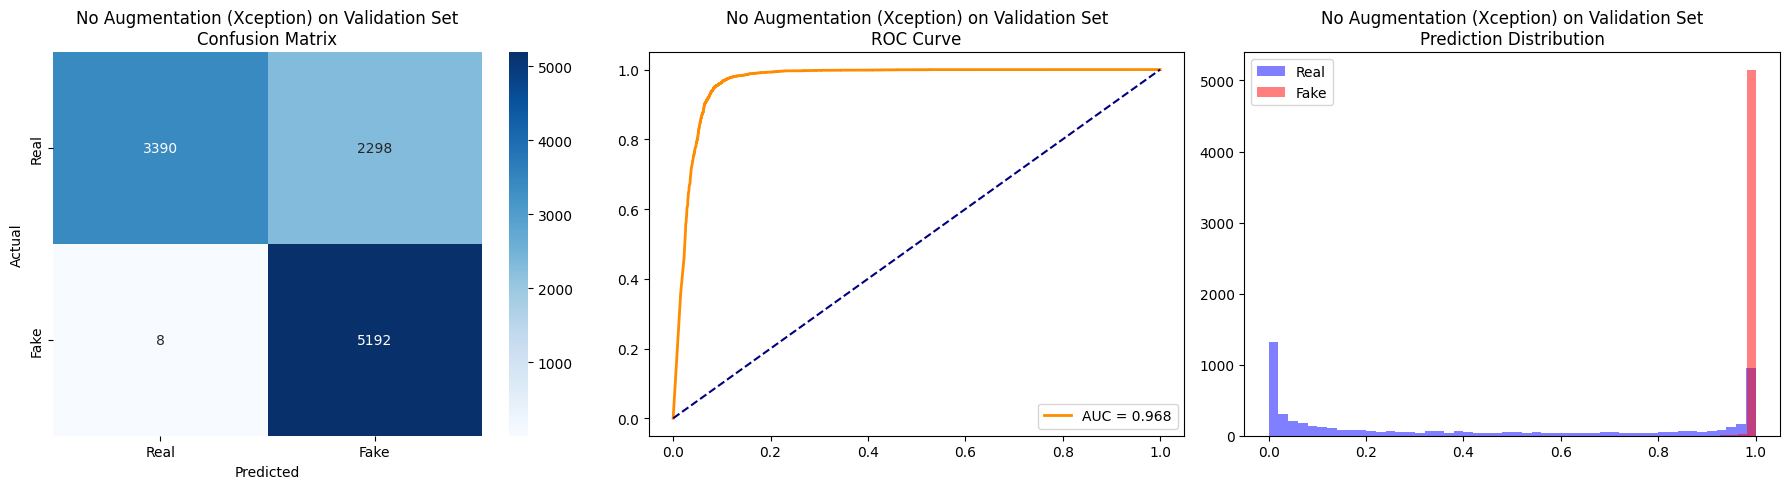

   ▶ Dataset: Test Set (10888장)
🚀 모델 로딩 중... (xception_no_aug.pth)


/usr/local/lib/python3.8/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/tmp/ipykernel_64032/3577255946.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pleas


📢 [No Augmentation (Xception) on Test Set] 성능 리포트
✅ Accuracy : 78.60%
✅ F1 Score : 0.8168
💾 그래프가 저장되었습니다: ./image/No_Augmentation_Xception_on_Test_Set.png


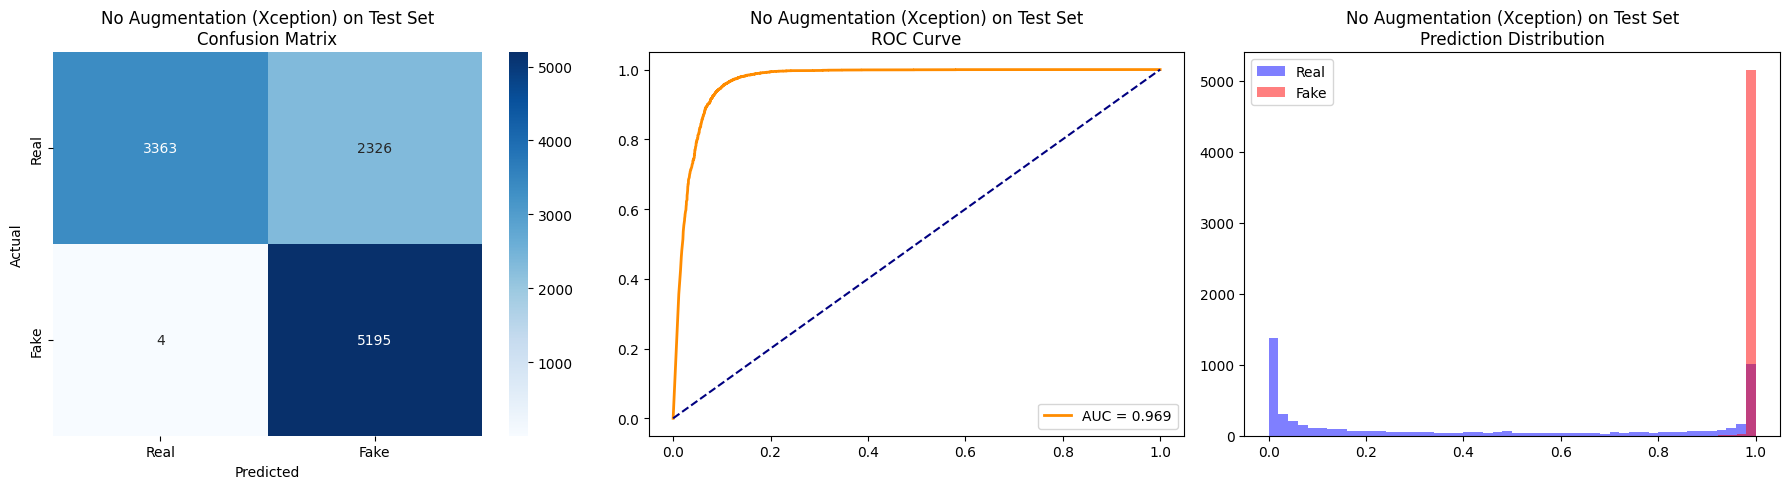

--------------------------------------------------------------------------------

🟦 [Model: With Augmentation (Xception)] 평가 시작...
   ▶ Dataset: Validation Set (10888장)
🚀 모델 로딩 중... (xception_with_aug.pth)


/usr/local/lib/python3.8/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/tmp/ipykernel_64032/3577255946.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pleas


📢 [With Augmentation (Xception) on Validation Set] 성능 리포트
✅ Accuracy : 92.96%
✅ F1 Score : 0.9312
💾 그래프가 저장되었습니다: ./image/With_Augmentation_Xception_on_Validation_Set.png


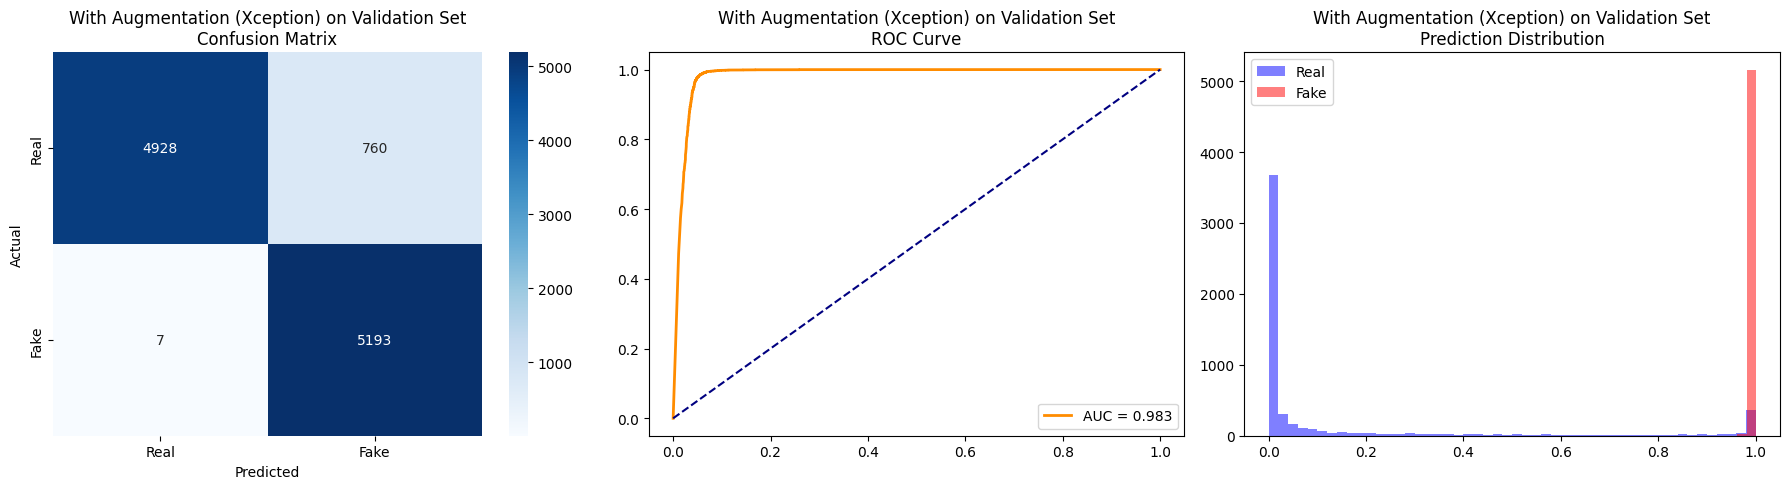

   ▶ Dataset: Test Set (10888장)
🚀 모델 로딩 중... (xception_with_aug.pth)


/usr/local/lib/python3.8/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/tmp/ipykernel_64032/3577255946.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pleas


📢 [With Augmentation (Xception) on Test Set] 성능 리포트
✅ Accuracy : 92.44%
✅ F1 Score : 0.9266
💾 그래프가 저장되었습니다: ./image/With_Augmentation_Xception_on_Test_Set.png


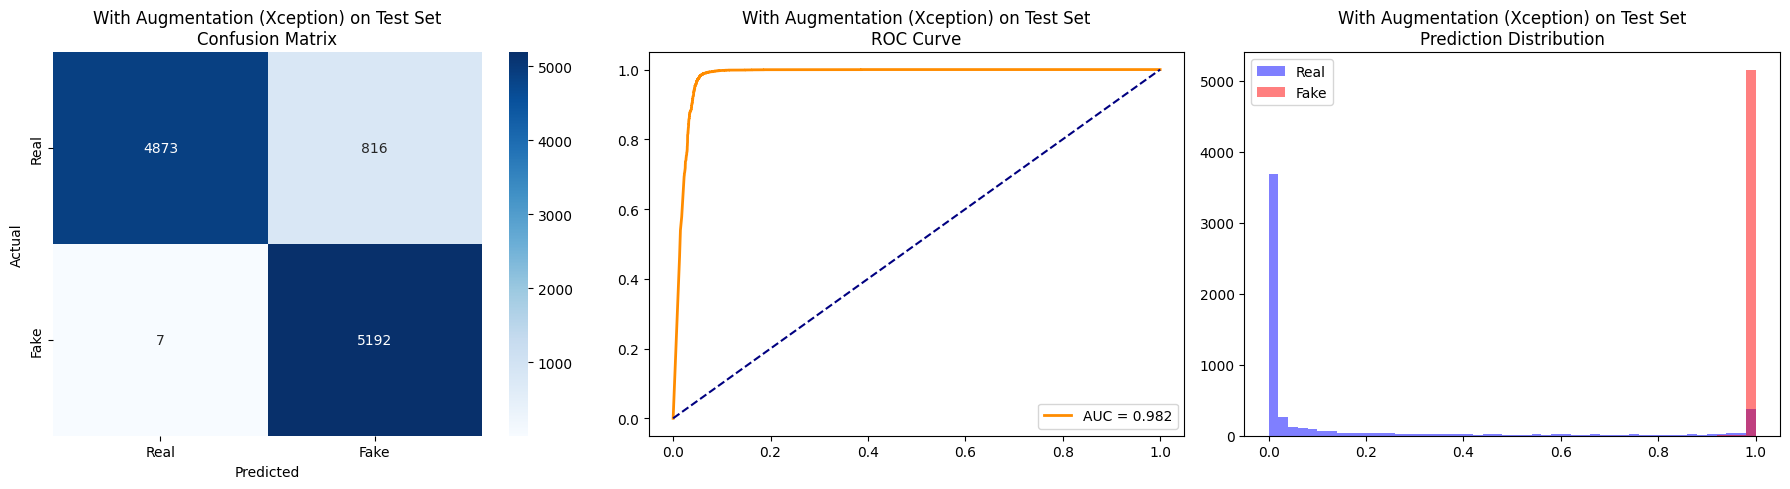

--------------------------------------------------------------------------------


In [18]:
# ==========================================
# 설정: 평가할 대상 목록
# ==========================================

# 1. 평가할 모델 파일들
target_models = [
    ("No Augmentation (Xception)", "xception_no_aug.pth"),
    ("With Augmentation (Xception)", "xception_with_aug.pth")
]

# 2. 평가할 데이터셋 (loaders_aug에서 꺼내옴)
# 주의: get_dataloaders를 실행한 상태여야 합니다.
if 'loaders_aug' in locals():
    target_datasets = [
        ("Validation Set", loaders_aug['val']), 
        ("Test Set", loaders_aug['test'])
    ]
else:
    print("❌ Error: 'loaders_aug'가 정의되지 않았습니다. 데이터 로더 생성 셀을 먼저 실행해주세요.")
    target_datasets = []

# ==========================================
# 실행 Loop
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if target_datasets:
    print(f"🧐 총 {len(target_models) * len(target_datasets)}번의 평가를 시작합니다.\n")

    for model_name, model_path in target_models:
        print(f"\n🟦 [Model: {model_name}] 평가 시작...")
        
        for dataset_name, loader in target_datasets:
            # 그래프 제목 생성
            full_title = f"{model_name} on {dataset_name}"
            
            print(f"   ▶ Dataset: {dataset_name} ({len(loader.dataset)}장)")
            
            # 추론 및 시각화
            y_true, y_probs = run_inference(model_path, loader, device)
            
            if y_true is not None:
                show_model_performance(y_true, y_probs, title=full_title)
                
        print("-" * 80) # 모델 간 구분선